В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Area under ROC score on Train dataset: 0.88%


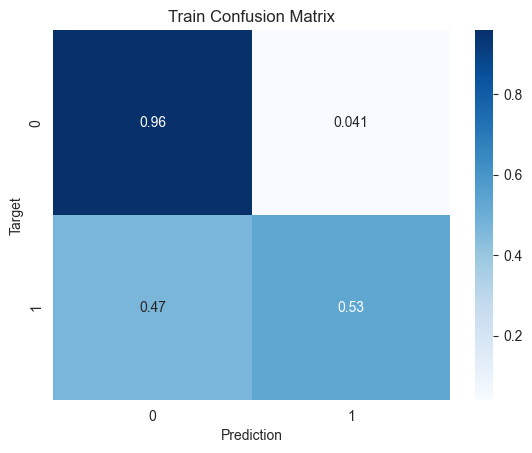

Area under ROC score on Validation dataset: 0.88%


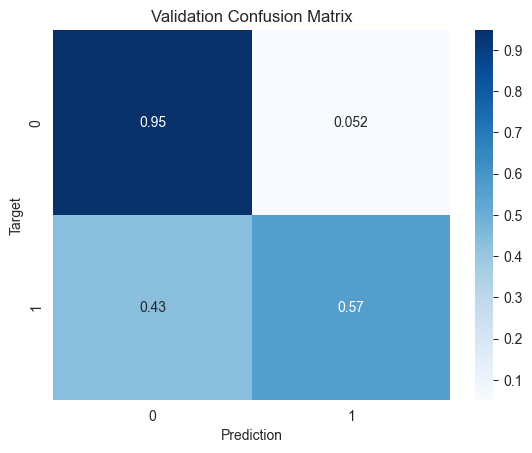

['logreg_model.joblib']

In [5]:
raw_df = pd.read_csv('../csv/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df.drop(columns=['CustomerId', 'Surname']), test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline.fit(train_inputs, train_targets)

# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict_proba(inputs)[:,1]
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    cf = confusion_matrix(targets, (preds > 0.5).astype(int), normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets.values, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets.values, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logreg_model.joblib')

In [6]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.92%


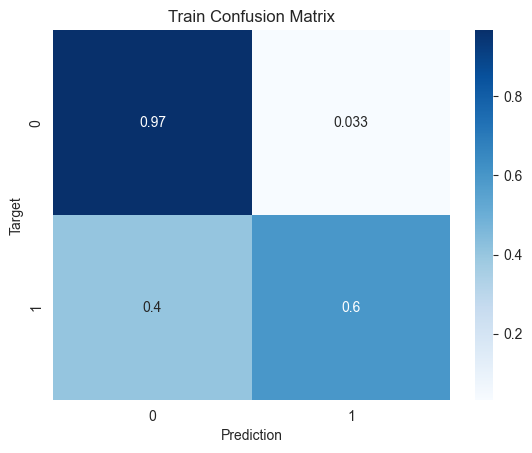

Area under ROC score on Validation dataset: 0.92%


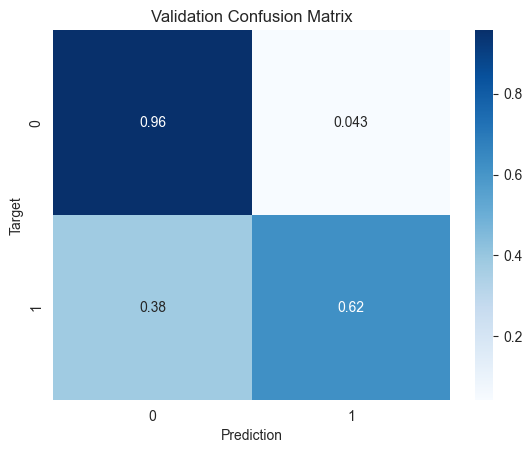

['logreg_model_pf.joblib']

In [7]:
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer_pf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=2))
])

preprocessor_pf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pf, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_pf = Pipeline(steps=[
    ('preprocessor', preprocessor_pf),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_pf.fit(train_inputs, train_targets)

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline_pf, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_pf, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logreg_model_pf.joblib')

In [8]:
model_pipeline_pf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures())]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [9]:
model_pipeline_pf[0].get_feature_names_out()

array(['num__1', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__HasCrCard', 'num__IsActiveMember',
       'num__Age^2', 'num__Age Tenure', 'num__Age Balance',
       'num__Age NumOfProducts', 'num__Age HasCrCard',
       'num__Age IsActiveMember', 'num__Tenure^2', 'num__Tenure Balance',
       'num__Tenure NumOfProducts', 'num__Tenure HasCrCard',
       'num__Tenure IsActiveMember', 'num__Balance^2',
       'num__Balance NumOfProducts', 'num__Balance HasCrCard',
       'num__Balance IsActiveMember', 'num__NumOfProducts^2',
       'num__NumOfProducts HasCrCard',
       'num__NumOfProducts IsActiveMember', 'num__HasCrCard^2',
       'num__HasCrCard IsActiveMember', 'num__IsActiveMember^2',
       'cat__Geography_France', 'cat__Geography_Germany',
       'cat__Geography_Spain', 'cat__Gender_Female', 'cat__Gender_Male'],
      dtype=object)

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.93%


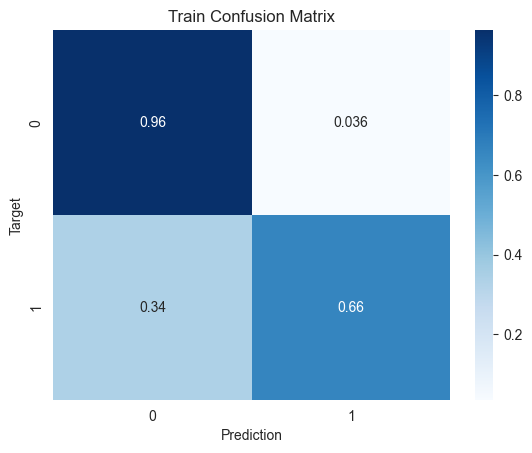

Area under ROC score on Validation dataset: 0.93%


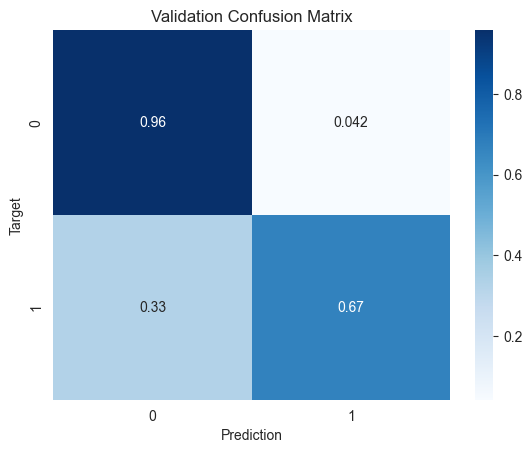

['logreg_model_pf4.joblib']

In [10]:
numeric_transformer_pf_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=4))
])

preprocessor_pf_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pf_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_pf_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_pf_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_pf_4.fit(train_inputs, train_targets)

# Evaluate on train and val set
train_preds = predict_and_plot(model_pipeline_pf_4, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_pf_4, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(model_pipeline, 'logreg_model_pf4.joblib')

In [29]:
numeric_transformer_pf_test = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=16))
])

preprocessor_pf_test = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pf_test, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_pf_test = Pipeline(steps=[
    ('preprocessor', preprocessor_pf_test),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_pf_test.fit(train_inputs, train_targets)

test_raw_df = pd.read_csv('../csv/test.csv')

test_inputs = test_raw_df[input_cols]

test_preds = model_pipeline_pf_test.predict_proba(test_inputs)[:,1]

test_raw_df['Exited'] = test_preds
submission = pd.read_csv('../csv/sample_submission.csv')
submission['Exited'] = test_raw_df['Exited']
submission.to_csv('../csv/submission_pynomial_features.csv', index=False)
submission['Exited'].head()

0    0.059676
1    0.009383
2    0.068478
3    0.453454
4    0.019284
Name: Exited, dtype: float64

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?